In [2]:
%pylab inline
#Autoreload so changing py files works
%load_ext autoreload
%autoreload 2
import gc, os, math, random

import numpy as np
from IPython.display import Image, display, clear_output
from matplotlib import pyplot as plt
import cv2
import time

#Only if you're using theano
#import theano
#theano.gpuarray.use('cuda')

backend = 'tensorflow'
os.environ['KERAS_BACKEND'] = backend
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from Util import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [77]:
#LOAD VIDEO
frame_size = False#(128, 128)
#chairColor = loadVideoFrames('Chair.mp4', max_frames=-1, resize=frame_size, gray=False)
#chair = loadVideoFrames('Chair.mp4', max_frames=-1, resize=frame_size, gray=True)
skip = 20
putinColor = loadVideoFrames('Putin Watching TV.mp4', max_frames=6, frame_skip=skip, resize=frame_size, gray=False)
putin = loadVideoFrames('Putin Watching TV.mp4', max_frames=6, frame_skip=skip, resize=frame_size, gray=True)

Loaded in: 0.6680381298065186
Loaded in: 0.7460427284240723


In [ ]:
#CREATE NETWORK

if backend == 'tensorflow':
    K.clear_session()

auto_encoder_opt = Adam(lr=0.0002)

encoder_input_size = frame_size + (1,)

momentum = 0.8

encoder_size = 3000

encoder_input = Input(shape=encoder_input_size)

def convLayer(x, res, kernel_size=1, strides=1):
    x = Conv2D(res, kernel_size=kernel_size, strides=strides)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def deConvLayer(x, res, kernel_size=1, strides=1, padding='valid'):
    x = Conv2DTranspose(res, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

x = convLayer(encoder_input, 32, kernel_size=6, strides=2)
x = convLayer(x, 64, kernel_size=6, strides=2)

x = deConvLayer(x, 64, kernel_size=6, strides=2)
decoder_output = deConvLayer(x, 3, kernel_size=6, strides=2)


auto_encoder = Model(encoder_input, decoder_output)
auto_encoder.compile(loss='mean_squared_error', optimizer=auto_encoder_opt)
auto_encoder.summary()

In [ ]:
from NetHistory import NetHistory
X_train = np.array(chair)
history = NetHistory()

In [ ]:
#TRAINING
auto_encoder.fit(X_train, X_train, batch_size=32, epochs=5, validation_split=0.8, callbacks=[history])

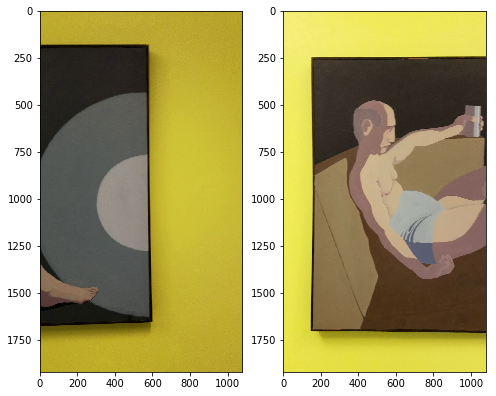

In [78]:
index1 = 1
index2 = 5

img_ = putinColor[index1]
img1 = putin[index1]

img = putinColor[index2]
img2 = putin[index2]

showImages([img_, img])

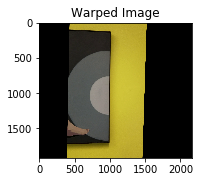

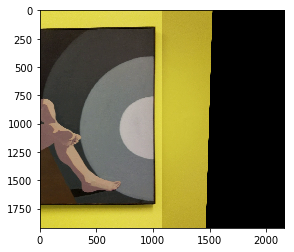

[[ 1.04078343e+00 -1.66787100e-02  4.33396443e+02]
 [ 5.33432000e-02  1.10262980e+00 -9.24029355e+01]
 [ 2.15737872e-05  1.16308869e-05  1.00000000e+00]]


In [63]:

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)
if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    #print(H)
else:
    raise AssertionError('Can’t find enough keypoints.')
dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img
cv2.imwrite('output.jpg',dst)
plt.imshow(dst)
plt.show()
print(H)

In [90]:
sift = cv2.xfeatures2d.SIFT_create()
matcher = cv2.BFMatcher()
def findHomography(ims, k=2, ratio=0.5, thing=5.0):
    H = []
    kp0, des0 = sift.detectAndCompute(ims[0],None)
    for i in range(1,len(ims)):
        kp1, des1 = sift.detectAndCompute(ims[i],None)
        matches = bf.knnMatch(des1,des2, k=k)
        good = []
        for m in matches:
            if m[0].distance < ratio*m[1].distance:
                good.append(m)
        matches = np.asarray(good)
        src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        h, masked = cv2.findHomography(src, dst, cv2.RANSAC, thing)
        H.append(h)
        kp0 = kp1
        des0 = des1
    return H

In [91]:
H = findHomography(putin)

In [92]:
H

[array([[ 1.04078343e+00, -1.66787100e-02,  4.33396443e+02],
        [ 5.33432000e-02,  1.10262980e+00, -9.24029355e+01],
        [ 2.15737872e-05,  1.16308869e-05,  1.00000000e+00]]),
 array([[ 1.00000000e+00,  1.23018232e-15, -1.81078745e-12],
        [ 1.84484210e-16,  1.00000000e+00, -5.75582728e-13],
        [-3.00526045e-19,  5.99349763e-19,  1.00000000e+00]]),
 array([[ 1.12695922e+00,  3.49607942e-03, -4.16608168e+02],
        [ 1.18687698e-01,  1.08748390e+00, -1.50341301e+02],
        [ 1.35724821e-04, -1.50162908e-06,  1.00000000e+00]]),
 array([[ 1.21062255e+00,  1.71849010e-02, -9.12879482e+02],
        [ 1.48337333e-01,  1.22829964e+00, -2.71442136e+02],
        [ 1.58496628e-04,  2.31056042e-05,  1.00000000e+00]]),
 None]